This notebook documents the TESS stability analysis simulation used to study the PID model of TESS (https://docs.google.com/document/d/1itcLysfKwT7jJlQxd7yT_1LQIfKY9QSHewR3SPb-vQE/).

# System model

The base model is as follows:

In [1]:
from IPython.display import Image
!cat model.glm

// TESS Stability Analysis base model

class system
{
    int64 t0; // time of last dynamic update
    double inertia[s]; // dynamic inertia constant (M)
    double damping[pu]; // dynamic model damping coefficient (D)
    double regulation[MW]; // regulation response (u)
    double supply[MW]; // scheduled generation
    double demand[MW]; // scheduled load
    double ramp[MW/h]; // scheduled ramp rate
    randomvar noise[MW]; // load noise disturbance (normally distributed)
    double drift[MW]; // load drift (integral of noise)
    double frequency[Hz]; // system frequency
    double Kp; // system frequency proportional control coefficient
    double Ki; // system frequency integral control coefficient
    double Kd; // system frequency derivative control coefficient
    double intfreq; // system frequency integral error
    randomvar power_price[$/MW/h]; // market power price
    double power_supply[MW]; // market power supply
    double power_demand[MW]; // market power demand
   

The base system model has a 20 GW nonimal loading with a 10 s inertial response with 1 pu damping. The system is responding to a 100 MW generation outage.  The system frequency regulation is a PID control with $K_P=0.02$, $K_I=K_P/30$, and $K_D=K_P/10$. The base system model is constructed in GridLAB-D as follows:

// TESS system response to 100MW loss of generation

module model;

clock 
{
    timezone "MST+7MDT";
    starttime "2020-01-01 00:00:00 MST";
    stoptime "2020-01-02 00:00:00 MST";
}

#include "model.glm"

object system
{
    name "system";
    inertia 10 s;
    damping 1 pu;
    regulation 0 MW;
    frequency 60 Hz;
    supply 19950 MW;
    demand 20000 MW;
    ramp ${RAMP:-0 MW/h};
    noise "type:normal(0,${NOISE:-0}); refresh:3;";
    drift integrate(noise);
    Kp 0.02;
    Ki ($Kp/30);
    Kd ($Kp/10);
    power_price "type:normal(${POWER_AVG:-0},${POWER_STD:-0}); refresh:300; min:-100; max:1000;";
    energy_price "type:normal(${ENERGY_AVG:-0},${ENERGY_STD:-0}); refresh:3600; min:-100; max:1000;";
    ramp_price "type:normal(${RAMP_AVG:-0},${RAMP_STD:-0}); refresh:30; min:-100; max:1000;";
    object recorder
    {
        file "csv/system.csv";
        interval -1;
        property "frequency,supply,demand,regulation,drift,ramp,power_price,power_supply,power_demand,energy_pri

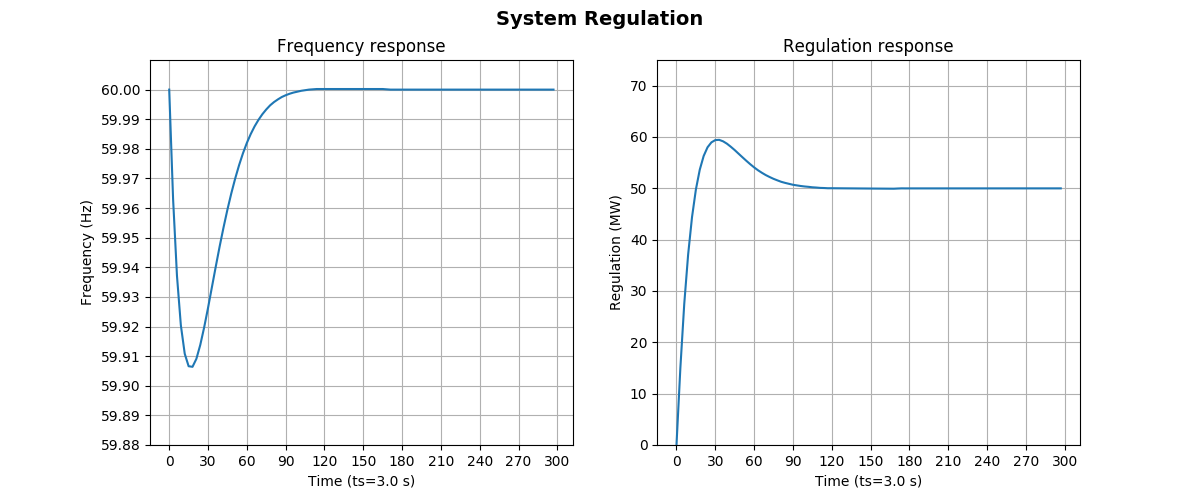

In [6]:
!cat system.glm
!gridlabd system.glm
Image("regulation/system.png")

In addition, the ramp-up and ramp-down scenarios are simulated using the following models:

// TESS system response to 100MW loss of generation under +100MW/h ramp

#define RAMP=100 MW/h

#include "system.glm"


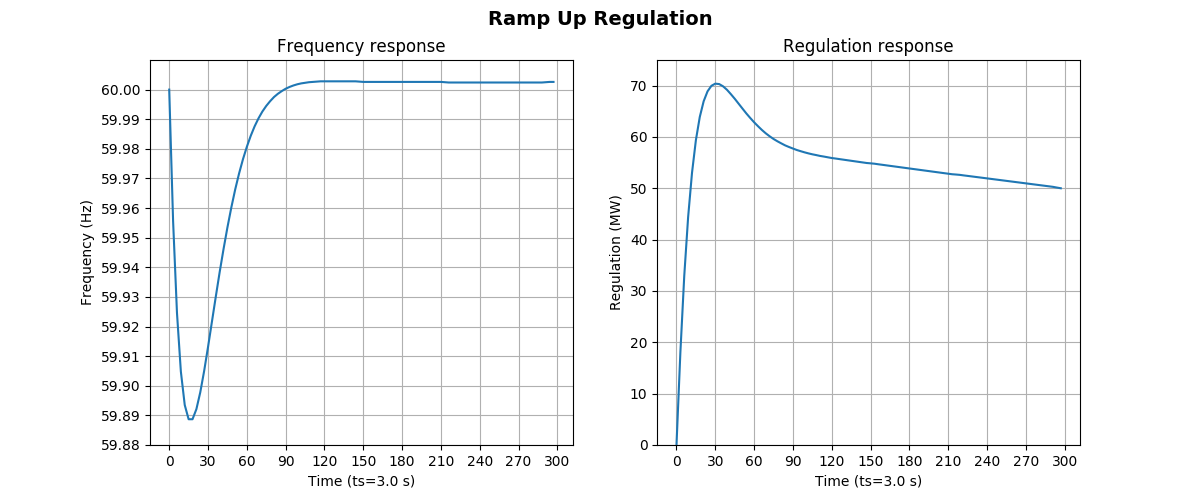

In [7]:
!cat ramp_up.glm
!gridlabd ramp_up.glm
Image("regulation/ramp_up.png")

// TESS system response to 100MW loss of generation under -100MW/h ramp

#define RAMP=-100 MW/h

#include "system.glm"


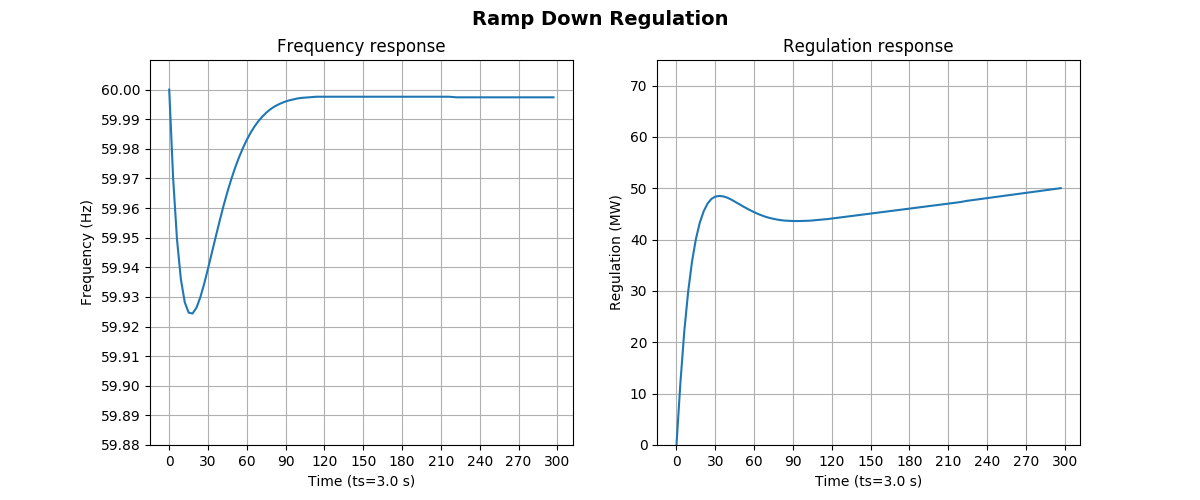

In [8]:
!cat ramp_down.glm
!gridlabd ramp_down.glm
Image("regulation/ramp_down.png")

Finally, load drift is added using the `NOISE` parameter

// TESS system response to 100MW loss of generation under +100MW/h ramp

#define NOISE=1

#include "system.glm"


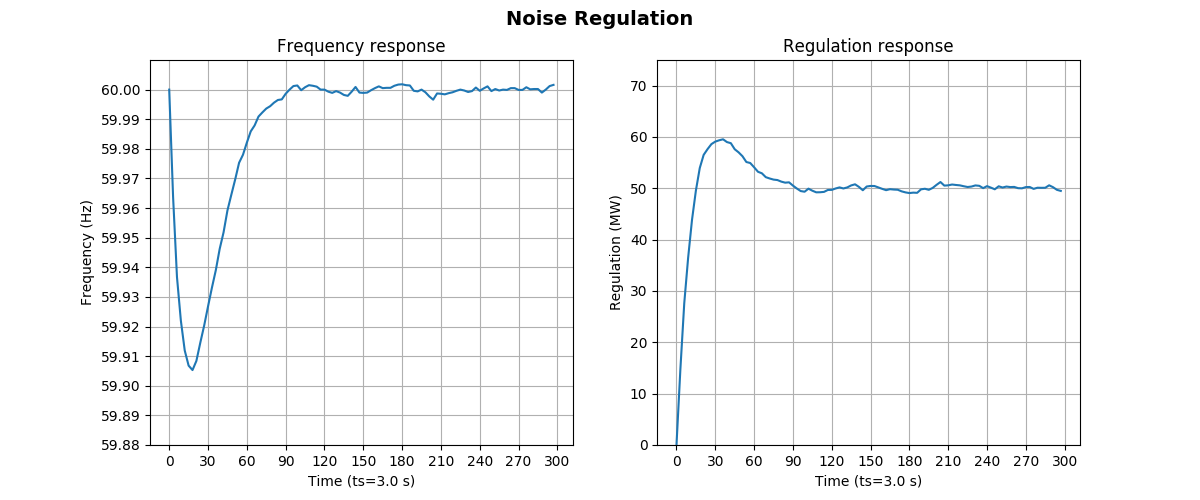

In [9]:
!cat noise.glm
!gridlabd noise.glm
Image("regulation/noise.png")

# Market model

The power market discovers the price at which total demand equals the constrained supply.  The total demand is the sum of the feeder unresponsive load and responsive load, and is always stored in the `active_load` property of the `feeder` object.  The constrained supply is the feeder capacity, and is always stored in the `capacity` property of the `feeder` object.  

The feeder supply price is the system power price, stored in the `power_price` property of the `system` object. The feeder's unresponsive load's price at the power market's price cap.

The power markets for the feeder clears every 5 minutes, and computes the `price`, `quantity`, and `margin` properties of the `power_market` objects. 

Demand resources may bid any price they wish.  For the purposes of this exercise, the Olympic bidding strategy is used, i.e., the desired state objective is converted to a price using the expected mean and standard deviation of the forward retail price.

// TESS system response to 100MW loss of generation

#define STOPTIME="2020-01-02 00:00:00 MST"
#define NOISE=1
#define RAMP=0

#define POWER_MARKET=yes
#define POWER_AVG=50
#define POWER_STD=10

#include "system.glm"


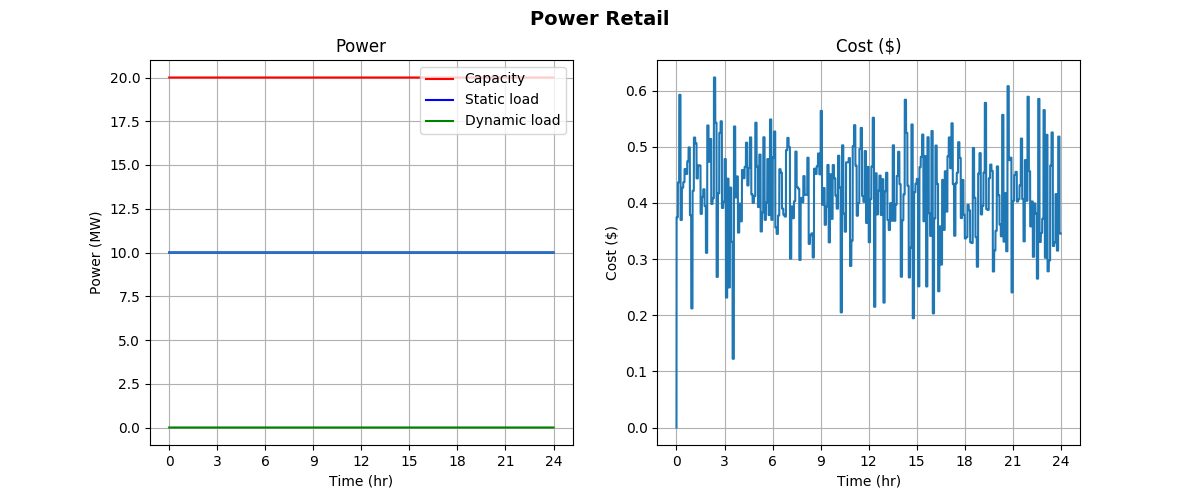

In [10]:
!cat power.glm
!gridlabd power.glm
Image("retail/power.png")

The energy market discovers that price at which the total stored energy equals the reserve requirements for the system. The energy storage demand is the reserve requirement

# Battery model

TODO